In [72]:
# Import data and prepare for model input

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import ast
#!pip install netCDF4
#import netCDF4

from google.colab import drive
drive.mount('/content/drive')

# Read in .csv from google drive (downloaded from Cli-Mate, 11 years of data)

filedir = '/content/drive/MyDrive/'
station1 = filedir + "cli-mate.csv"
station_data = pd.read_csv(station1, skiprows=7, skipfooter=17, usecols=[0,1,2,3,4,5], engine="python") # reduce rows to only daily data
station_data = station_data.drop(["SNWD"], axis=1) #drop unnecssary columns (too many missing values to include in model)
station_data.replace({"T":0}, inplace=True) # Convert trace values to 0
cols_to_check = ['PRCP', "TMAX", "TMIN", "SNOW"]
station_data = station_data[~station_data[cols_to_check].apply(lambda row: row.astype(str).str.contains("M").any(), axis=1)] #Check and remove any missing values (M) in columns

# Some columns contain strings and more than one numeric value, need to fix these

def safe_convert(val):
    try:
        # Try to evaluate stringified lists to actual lists and check for numeric content
        if isinstance(val, str):
            val = ast.literal_eval(val)  # This will safely evaluate strings like "['111', '2911']"
        # If it's a list, pick the first element
        if isinstance(val, list):
            return pd.to_numeric(val[0], errors='coerce')
        else:
            return pd.to_numeric(val, errors='coerce')
    except (ValueError, SyntaxError):
        # If conversion fails, return NaN
        return float('nan')

station_data[cols_to_check] = station_data[cols_to_check].map(safe_convert) #Apply safe conversion to each value in the selected columns
valid_mask = station_data[cols_to_check].notna()  #Create mask: valid if all selected columns are numeric
rows_to_keep = valid_mask.all(axis=1)
station_data = station_data[rows_to_keep].copy() # Filter the original DataFrame and overwrite station_data

# Convert date to datetime object
station_data["Total Precip"] = station_data["PRCP"] + station_data["SNOW"] #Create new column for total precipitation (includes rain and snow which matches ERA5 total precipiation)
station_data['Date'] = pd.to_datetime(station_data['Date']) #Convert weather station date to datetime object


# Read in streamflow data from USGS

streamflow = filedir + "USGS_Streamflow.csv"
streamflow = pd.read_csv(streamflow)
streamflow = streamflow.drop(['agency_cd', 'site_no', '155116_00060_00003_cd'], axis=1) # drop other columns
streamflow = streamflow.rename(columns={'155116_00060_00003': 'Streamflow', "datetime":"Date"})
streamflow = streamflow.drop(0)
streamflow['Date'] = pd.to_datetime(streamflow['Date'])# convert date to datetime object
streamflow["Streamflow"] = streamflow["Streamflow"].shift(2) #shift to account for delay in rain vs river streamflow increase
streamflow = streamflow.dropna() #get rid of all missing values (12)

# Merge weather station data and streamflow data

station_data = pd.merge(station_data, streamflow, on='Date')

# Read in NetCDF ERA5 data usign xarray from google drive (11 years of data)
# Due to data download restrictions each year had to be downloaded as separate file, combined to single netcdf

# Explore the ERA5 variables and attributes (precipitaiton is represented by "tp" with units meters, temperature by "t2m" with units kelvin)

#nc_dataset = netCDF4.Dataset(fname, 'r')  # 'r' for read mode
#print("\nVariable Attributes:")
#for var_name, variable in nc_dataset.variables.items():
    #print(f"Variable: {var_name}")
    #for attr_name in variable.ncattrs():
        #print(f"\t{attr_name}: {variable.getncattr(attr_name)}")


# ERA5 Precipiation Data

combined_precip = xr.open_mfdataset('/content/drive/MyDrive/precip_*.nc',combine = "nested", concat_dim="valid_time") #open every netcdf year and combine to one dataset
#combined_precip_test.to_netcdf(filedir + "Combined_ERA5_Precip.nc") # save as netcdf in my cloned respository folder'
#combined_precip = xr.open('/content/drive/MyDrive/Combined_ERA5_Precip.nc")
combined_precip['valid_time'] = pd.to_datetime(combined_precip['valid_time'].values).tz_localize("UTC").tz_convert("Asia/Kamchatka").tz_localize(None) #Weather station data is collected 7am to 7am, time zone conversion factors that
combined_era = combined_precip["tp"] * 39.3701 #Convert precip to inches
combined_era.attrs['units'] = 'inches' # update units in xarray
combined_era = combined_era.sel(longitude=slice(-89.0642)) # Get only snowfall values at longitude of weather station location
combined_era = combined_era.sel(latitude =slice(42.6375)) # Get only snowfall values from latitude of weather station location
combined_era = combined_era.resample(valid_time="1d").sum() #group data by day
era_df = combined_era.to_dataframe(name='ERA5 Precip').reset_index() # turn xarray into dataframe
era_df = era_df.drop(['latitude', 'longitude', 'number'], axis=1) # drop other columns
era_df = era_df.rename(columns={'valid_time': 'Date'}) # Change date format for weather station to match weather station
era_df['Date'] = pd.to_datetime(era_df['Date']) # convert date to datetime object


# ERA5 Temperature Data

combined_temp = xr.open_mfdataset('/content/drive/MyDrive/temp_*.nc',combine = "nested", concat_dim="valid_time")
#combined_temp_test.to_netcdf(filedir + "Combined_ERA5_Temp.nc") # save as netcdf in my cloned respository folder'
#combined_temp = xr.open('/content/drive/MyDrive/Combined_ERA5_Temp.nc")
combined_temp['valid_time'] = pd.to_datetime(combined_temp['valid_time'].values).tz_localize("UTC").tz_convert("Asia/Kamchatka").tz_localize(None)
combined_era_temp = (combined_temp["t2m"]- 273.15) * 1.8 + 32 #Convert temp to f
combined_era_temp.attrs['units'] = 'F' # update units in xarray
combined_era_temp = combined_era_temp.sel(longitude=slice(-89.0642)) # Get only snowfall values at longitude of weather station location
combined_era_temp = combined_era_temp.sel(latitude =slice(42.6375)) # Get only snowfall values from latitude of weather station location
combined_era_temp = combined_era_temp.resample(valid_time="1d").mean() #group data by day
era_df_temp = combined_era_temp.to_dataframe(name='ERA5 Temp').reset_index() # turn xarray into dataframe
era_df_temp = era_df_temp.drop(['latitude', 'longitude', 'number'], axis=1) # drop other columns
era_df_temp = era_df_temp.rename(columns={'valid_time': 'Date'}) # Change date format for weather station to match weather station
era_df_temp['Date'] = pd.to_datetime(era_df_temp['Date']) #convert date to datetime object

# Merge weather station and ERA5 datasets together

final_data = pd.merge(station_data, era_df, on='Date', how="inner")
final_data = pd.merge(final_data, era_df_temp, on='Date', how="inner")


# Create new columns to represent seasonality

final_data['day of year'] = final_data['Date'].dt.dayofyear
final_data['dayofyear_sin'] = np.sin(2 * np.pi * final_data['day of year'] / 365)
final_data['dayofyear_cos'] = np.cos(2 * np.pi * final_data['day of year'] / 365)

# Save final dataset

final_data.to_csv(filedir + "Final_RF_Dataset.csv") # saves dataframe as .csv in my cloned respository folder

# Plot the ERA5 and Weather Station data throughout time
#final_data.set_index("Date", inplace=True)
#final_data['PRCP'] = pd.to_numeric(final_data['PRCP'], errors='coerce')
#final_data["PRCP"].plot(color="blue")

# Label the x-axis, y-axis, and give the plot a title
#plt.xlabel("Date")
#plt.ylabel("Precipitation (inches)")
#plt.title("ERA5 Precipitation Data (2014-2024)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Create Random Forest Model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# Set up feature (X) and target (y)

features = ["ERA5 Precip", "ERA5 Temp","TMIN", "TMAX", "Streamflow", "day of year"]
X = final_data[features]
y = final_data['Total Precip']

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Grid Search for Random Forest Model

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2')

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

# Create and train the model
model_forest = RandomForestRegressor(n_estimators=150, random_state=42, min_samples_leaf=5) #parameters determined from GridSearch
model_forest.fit(X_train, y_train)

# Predict using testing dataset

y_pred_forest = model_forest.predict(X_test)



Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 150}


In [90]:
# Evaulating Metrics

from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

# R-Squared and RMSE Metrics

r2_forest = r2_score(y_test, y_pred_forest)

print('Random Forest Model Metrics, RMSE:', round(mean_squared_error(y_test, y_pred_forest), 2), ", R²:", round(r2_forest, 2), ", MAE:", round(mean_absolute_error(y_test, y_pred_forest), 2))

# K-Fold Cross Validation

k = 5
cv_scores=cross_val_score(model_forest, X, y, cv=k)
print(f"Average R² from Random Forest Model Cross-Validation: {cv_scores.mean():.3f}")

# Metrics for ERA5 Gap Filling Method

y_test_indices = y_test.index #Find indices for test dataset
test = final_data.loc[y_test.index, 'ERA5 Precip'] # Find ERA5 values that match y_test indices
r2_era = r2_score(y_test, test)
print("R2 for Gap Filling using ERA5 values:" ,round(r2_era, 2))


# Add nearest weather station to dataset

closest_station = filedir + "milton.csv"
closest = pd.read_csv(closest_station, skiprows=7, skipfooter=17, usecols=[0,1], engine="python")
#closest = closest.drop(["TMAX", "TMIN", "SNWD", "SNOW"], axis=1)
closest.replace({"T":0}, inplace=True) #Convert Trace values to 0
closest['Date'] = pd.to_datetime(closest['Date']) #convert date to datetime object
closest = closest.rename(columns={"PRCP": "Neighbor PRCP"}) #Rename column so no confusion
data2 = pd.merge(final_data, closest, on="Date") #merge weather station record with main dataset
data2 = data2[~data2["Neighbor PRCP"].astype(str).str.contains('M')] #Get rid of any missing values in new dataset

# Metrics for Closest Station Gap Filling Method  (10.5 miles away)

y = data2['PRCP']
X = data2[features]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42) #create new training/testing datasets as missing values may have affected length of original datset
y_test_indices = y_test2.index #Find indices for test dataset
neighbor_rain = data2.loc[y_test2.index, 'Neighbor PRCP'] #extract values from nearest weather station
r2_neighbor = r2_score(y_test2, neighbor_rain)
print("R2 for Closest Weather Station Method:", r2_neighbor)


# Add station 45 miles away to dataset

next_closest = filedir + "dane.csv"
next = pd.read_csv(next_closest, skiprows=7, skipfooter=17, usecols=[0,1,2,3,4,5], engine="python")
next.replace({"T":0}, inplace=True) # Convert trace values to 0
next = next.drop(["TMIN", "TMAX", "SNWD", "SNOW"], axis=1)
next.replace({"T":0}, inplace=True) #Convert Trace values to 0
next['Date'] = pd.to_datetime(next['Date']) #convert date to datetime object
next = next.rename(columns={"PRCP": "Next PRCP"}) # Rename column so no confusion
data3 = pd.merge(final_data, next, on="Date") #Merge weather station data with main dataset
data3 = data3[~data3["Next PRCP"].astype(str).str.contains('M')] #Get rid of any missing values in new dataset


# Metrics for Gap Filling using Weather Station 45 miles away

y = data3['PRCP']
X = data3[features]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42) #Set up new training/testing datasets to account for missing value effects
y_test_indices = y_test3.index #Find indices for test dataset
next_precip = data3.loc[y_test3.index, 'Next PRCP'] #extract values from weather station
r2_next = r2_score(y_test3, next_precip)
print("R2 for Gap Filling using Weather Station 45 miles away", r2_next)



Random Forest Model Metrics, RMSE: 0.34 , R²: 0.57 , MAE: 0.16
Average R² from Random Forest Model Cross-Validation: 0.580
R2 for Gap Filling using ERA5 values: 0.1
R2 for Closest Weather Station Method: 0.7232758630587832
R2 for Gap Filling using Weather Station 45 miles away -0.2581993465229806


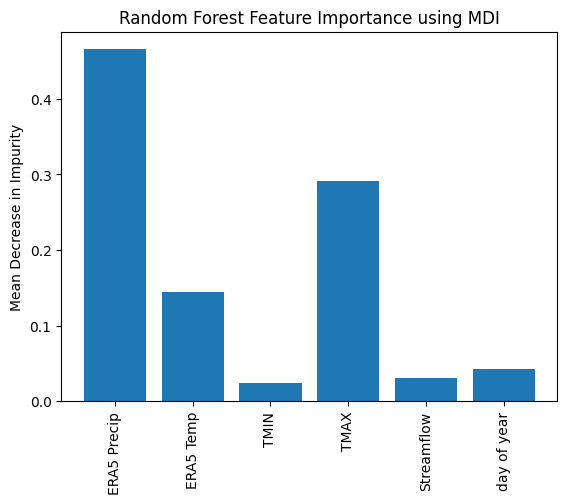

In [91]:
# Random Forest Model Feature Importance

importance = model_forest.feature_importances_
x = range(0,len(importance))
plt.bar(x, importance)
plt.xticks(x, features, rotation='vertical')
plt.title("Random Forest Feature Importance using MDI")
plt.ylabel("Mean Decrease in Impurity")
plt.show()


Text(0, 0.5, 'R2 Values')

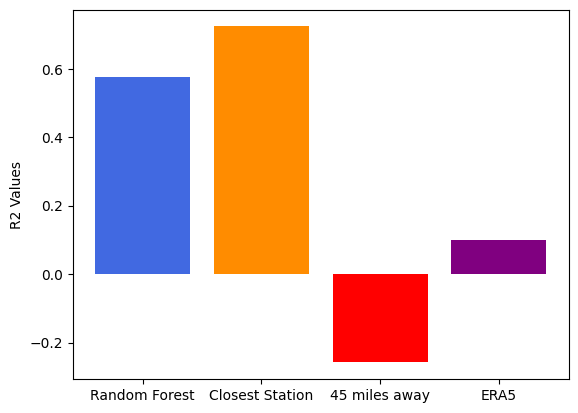

In [92]:
# Bar Plot Visualization of R-Squared Scores

labels = ['Random Forest', 'Closest Station', "45 miles away", "ERA5"]
scores = [r2_forest, r2_neighbor, r2_next, r2_era]
plt.bar(labels, scores, color=['royalblue', 'darkorange', "red", "purple"])
plt.ylabel('R2 Values')


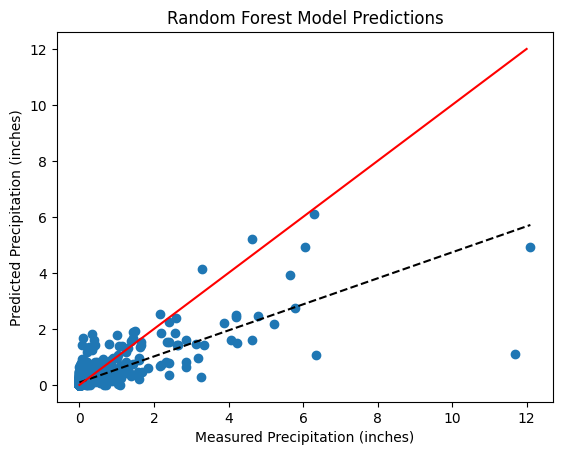

In [93]:
# Plot measured vs predicted values

import seaborn as sns


# Create linear regression line
linear_regression = np.polyfit(y_test, y_pred_forest, deg=1) #get coefficients
regression_line = linear_regression[0] * y_test + linear_regression[1] #create regression line
df = pd.DataFrame()
df = df.assign(measured=y_test, regression=regression_line)
df.columns = df.columns.str.strip()
sns.lineplot(x="measured", y="regression", data=df, color="black", linestyle="dashed")
x_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
y_values = x_values
plt.plot(x_values, y_values, linestyle='-', color='red', label="1:1 Line")
plt.legend([],[], frameon=False)

plt.scatter(y_test, y_pred_forest)
plt.xlabel("Measured Precipitation (inches)")
plt.ylabel("Predicted Precipitation (inches)")
plt.title("Random Forest Model Predictions")
plt.show()
